In [1]:
# pd np matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
# warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
url = 'https://redfin-public-data.s3.us-west-2.amazonaws.com/redfin_market_tracker/redfin_metro_market_tracker.tsv000.gz'

start = time.time()
df = pd.read_csv(url, compression = 'gzip', sep='\t', on_bad_lines='skip')
# end time
execution = (time.time()-start)
print('Execution time in minutes: ' + str(round(execution / 60, 2)))
print('Num of rows: ', len(df))
print('Num of columns: ', len(df.columns))
df.head()


Execution time in minutes: 0.57
Num of rows:  462515
Num of columns:  58


period_begin  period_end  period_duration region_type  region_type_id  \
0   2020-01-01  2020-01-31               30       metro              -2   
1   2019-09-01  2019-09-30               30       metro              -2   
2   2018-10-01  2018-10-31               30       metro              -2   
3   2020-08-01  2020-08-31               30       metro              -2   
4   2018-12-01  2018-12-31               30       metro              -2   

   table_id is_seasonally_adjusted                      region  city  state  \
0     13900                      f     Bismarck, ND metro area   NaN    NaN   
1     24820                      f   Greenville, OH metro area   NaN    NaN   
2     22540                      f  Fond du Lac, WI metro area   NaN    NaN   
3     25860                      f      Hickory, NC metro area   NaN    NaN   
4     10780                      f   Alexandria, LA metro area   NaN    NaN   

   ... sold_above_list_yoy price_drops  price_drops_mom  price_drops_yoy  \
0  ...            0.000000         NaN              NaN              NaN   
1  ...            0.000000         NaN              NaN              NaN   
2  ...            0.045491    0.314356         0.099045         0.109228   
3  ...            0.067139    0.041494        -0.008735        -0.040757   
4  ...            0.000000         NaN              NaN              NaN   

   off_market_in_two_weeks  off_market_in_two_weeks_mom  \
0                 0.333333                     0.333333   
1                      NaN                          NaN   
2                 0.080000                     0.014426   
3                 0.315789                     0.140789   
4                 0.000000                          NaN   

   off_market_in_two_weeks_yoy  parent_metro_region  \
0                     0.333333         Bismarck, ND   
1                          NaN       Greenville, OH   
2                    -0.080000      Fond du Lac, WI   
3                     0.269278          Hickory, NC   
4                          NaN       Alexandria, LA   

   parent_metro_region_metro_code         last_updated  
0                           13900  2024-07-15 17:39:34  
1                           24820  2024-07-15 17:39:34  
2                           22540  2024-07-15 17:39:34  
3                           25860  2024-07-15 17:39:34  
4                           10780  2024-07-15 17:39:34  

[5 rows x 58 columns]

In [3]:
# read redfin_metro_market_tracker.tsv000 into df
# df = pd.read_csv('redfin_metro_market_tracker.tsv000', sep='\t')

In [4]:
# Set the option to display all columns when printing DataFrames
pd.set_option('display.max_columns', None)

# List of parent metro regions you want to filter on
parent_metro_region = ["Boston, MA", "Chicago, IL", "San Francisco, CA", "New York, NY", "Austin, TX", "Miami, FL", "Denver, CO"]

# List of city names corresponding to the parent metro regions
city_list = ['Boston', 'Chicago', 'San Francisco', 'New York', 'Austin', 'Miami', 'Denver']

# Filter the DataFrame df to include only rows with parent metro regions in parent_metro_region list
qf = df[df['parent_metro_region'].isin(parent_metro_region)]

# Extract the city name from the 'region' column and create a new 'city' column
qf['city'] = qf['region'].str.extract('({})'.format('|'.join(city_list)), expand=False)

# Select specific columns for the final DataFrame
qf = qf[['period_begin', 'period_end', 'city', 'property_type', 'median_sale_price']]

# Group the DataFrame by 'city', then sort each group by 'period_end' in ascending order
qf = qf.groupby('city').apply(lambda x: x.sort_values('period_end', ascending=True)).reset_index(drop=True)

In [5]:
def get_data_availability_stats(df):
    
    """
    Calculate data availability statistics for different cities and property types.

    Parameters:
    df (DataFrame): Input DataFrame containing real estate data.

    Returns:
    DataFrame: A DataFrame summarizing data availability for each city, including the first and last data points,
    the count of data points, and counts for different property types.
    """

    # Calculate the count of data points for each city
    city_value_counts = df['city'].value_counts()

    # Calculate the first and last dates for each city
    city_first_last_dates = df.groupby('city')['period_end'].agg(['first', 'last']).reset_index()

    # Map the value counts to the 'city' column in 'city_first_last_dates'
    city_first_last_dates['count'] = city_first_last_dates['city'].map(city_value_counts)

    # Calculate counts for different property types in each city
    city_first_last_counts = df.groupby(['city', 'property_type']).size().reset_index(name='property_type_count')

    # Pivot the property type counts to a wide format
    city_first_last_pivot = city_first_last_counts.pivot(index='city', columns='property_type',
                                                        values='property_type_count')
    city_first_last_pivot = city_first_last_pivot.reset_index()
    city_first_last_pivot.index.name = None

    # Merge data availability statistics with property type counts
    city_first_last_stats = city_first_last_dates.merge(city_first_last_pivot, on='city')

    return city_first_last_stats

In [6]:
get_data_availability_stats(qf)

city       first        last  count  All Residential  Condo/Co-op  \
0         Austin  2012-01-31  2024-06-30    750              150          150   
1         Boston  2012-01-31  2024-06-30    750              150          150   
2        Chicago  2012-01-31  2024-06-30    750              150          150   
3         Denver  2012-01-31  2024-06-30    750              150          150   
4          Miami  2012-01-31  2024-06-30    750              150          150   
5       New York  2015-05-31  2024-06-30    550              110          110   
6  San Francisco  2012-01-31  2024-06-30    750              150          150   

   Multi-Family (2-4 Unit)  Single Family Residential  Townhouse  
0                      150                        150        150  
1                      150                        150        150  
2                      150                        150        150  
3                      150                        150        150  
4                      150                        150        150  
5                      110                        110        110  
6                      150                        150        150

In [7]:
stats_df = get_data_availability_stats(qf)
# Find the maximum of the first dates and the minimum of the last dates
common_start_date = stats_df['first'].max()
common_end_date = stats_df['last'].min()

In [8]:
# convert period_end to datetime col
qf['period_end'] = pd.to_datetime(qf['period_end'])

# Filter the DataFrame to include data within the specified date range and for 'All Residential' property type
filtered_df = qf[(qf['period_end'] >= common_start_date) & (qf['period_end'] <= common_end_date) & (qf['property_type'] == 'All Residential')]# 

## Data Filtering and Alignment

- The purpose of filtering and aligning the data is to ensure that we have a consistent and common dataset for analysis and modeling. By selecting the 'All Residential' property type and a specific date range from May 31, 2015, to June 30, 2023, we create a standardized dataset that allows for meaningful and comparable analyses across different cities. <br>

In [9]:
get_data_availability_stats(filtered_df)

city      first       last  count  All Residential
0         Austin 2015-05-31 2024-06-30    110              110
1         Boston 2015-05-31 2024-06-30    110              110
2        Chicago 2015-05-31 2024-06-30    110              110
3         Denver 2015-05-31 2024-06-30    110              110
4          Miami 2015-05-31 2024-06-30    110              110
5       New York 2015-05-31 2024-06-30    110              110
6  San Francisco 2015-05-31 2024-06-30    110              110

In [10]:
# Calculate the average median sale price for each city

# Group the DataFrame 'filtered_df' by 'period_end' and calculate the mean of 'median_sale_price', then reset the index
city_average_prices = filtered_df.groupby(['period_end'])['median_sale_price'].mean().reset_index()

# Convert the 'median_sale_price' column to integers (assuming it contains float values)
city_average_prices['median_sale_price'] = city_average_prices['median_sale_price'].astype(int)

# Set the 'city' column to 'Average of 7 City' for all rows
city_average_prices['city'] = 'Average of 7 City'

# Set the 'property_type' column to 'All Residential' for all rows
city_average_prices['property_type'] = 'All Residential'

# Set the 'period_begin' column based on the 'period_begin' values of the 'Austin' city
# Assuming 'Austin' is one of the cities in 'filtered_df'
city_average_prices['period_begin'] = filtered_df[filtered_df['city'] == 'Austin']['period_begin'].tolist()

In [11]:
filtered_df = pd.concat([filtered_df, city_average_prices], ignore_index=True)

In [12]:
filtered_df['city'].value_counts()

city
Austin               110
Boston               110
Chicago              110
Denver               110
Miami                110
New York             110
San Francisco        110
Average of 7 City    110
Name: count, dtype: int64

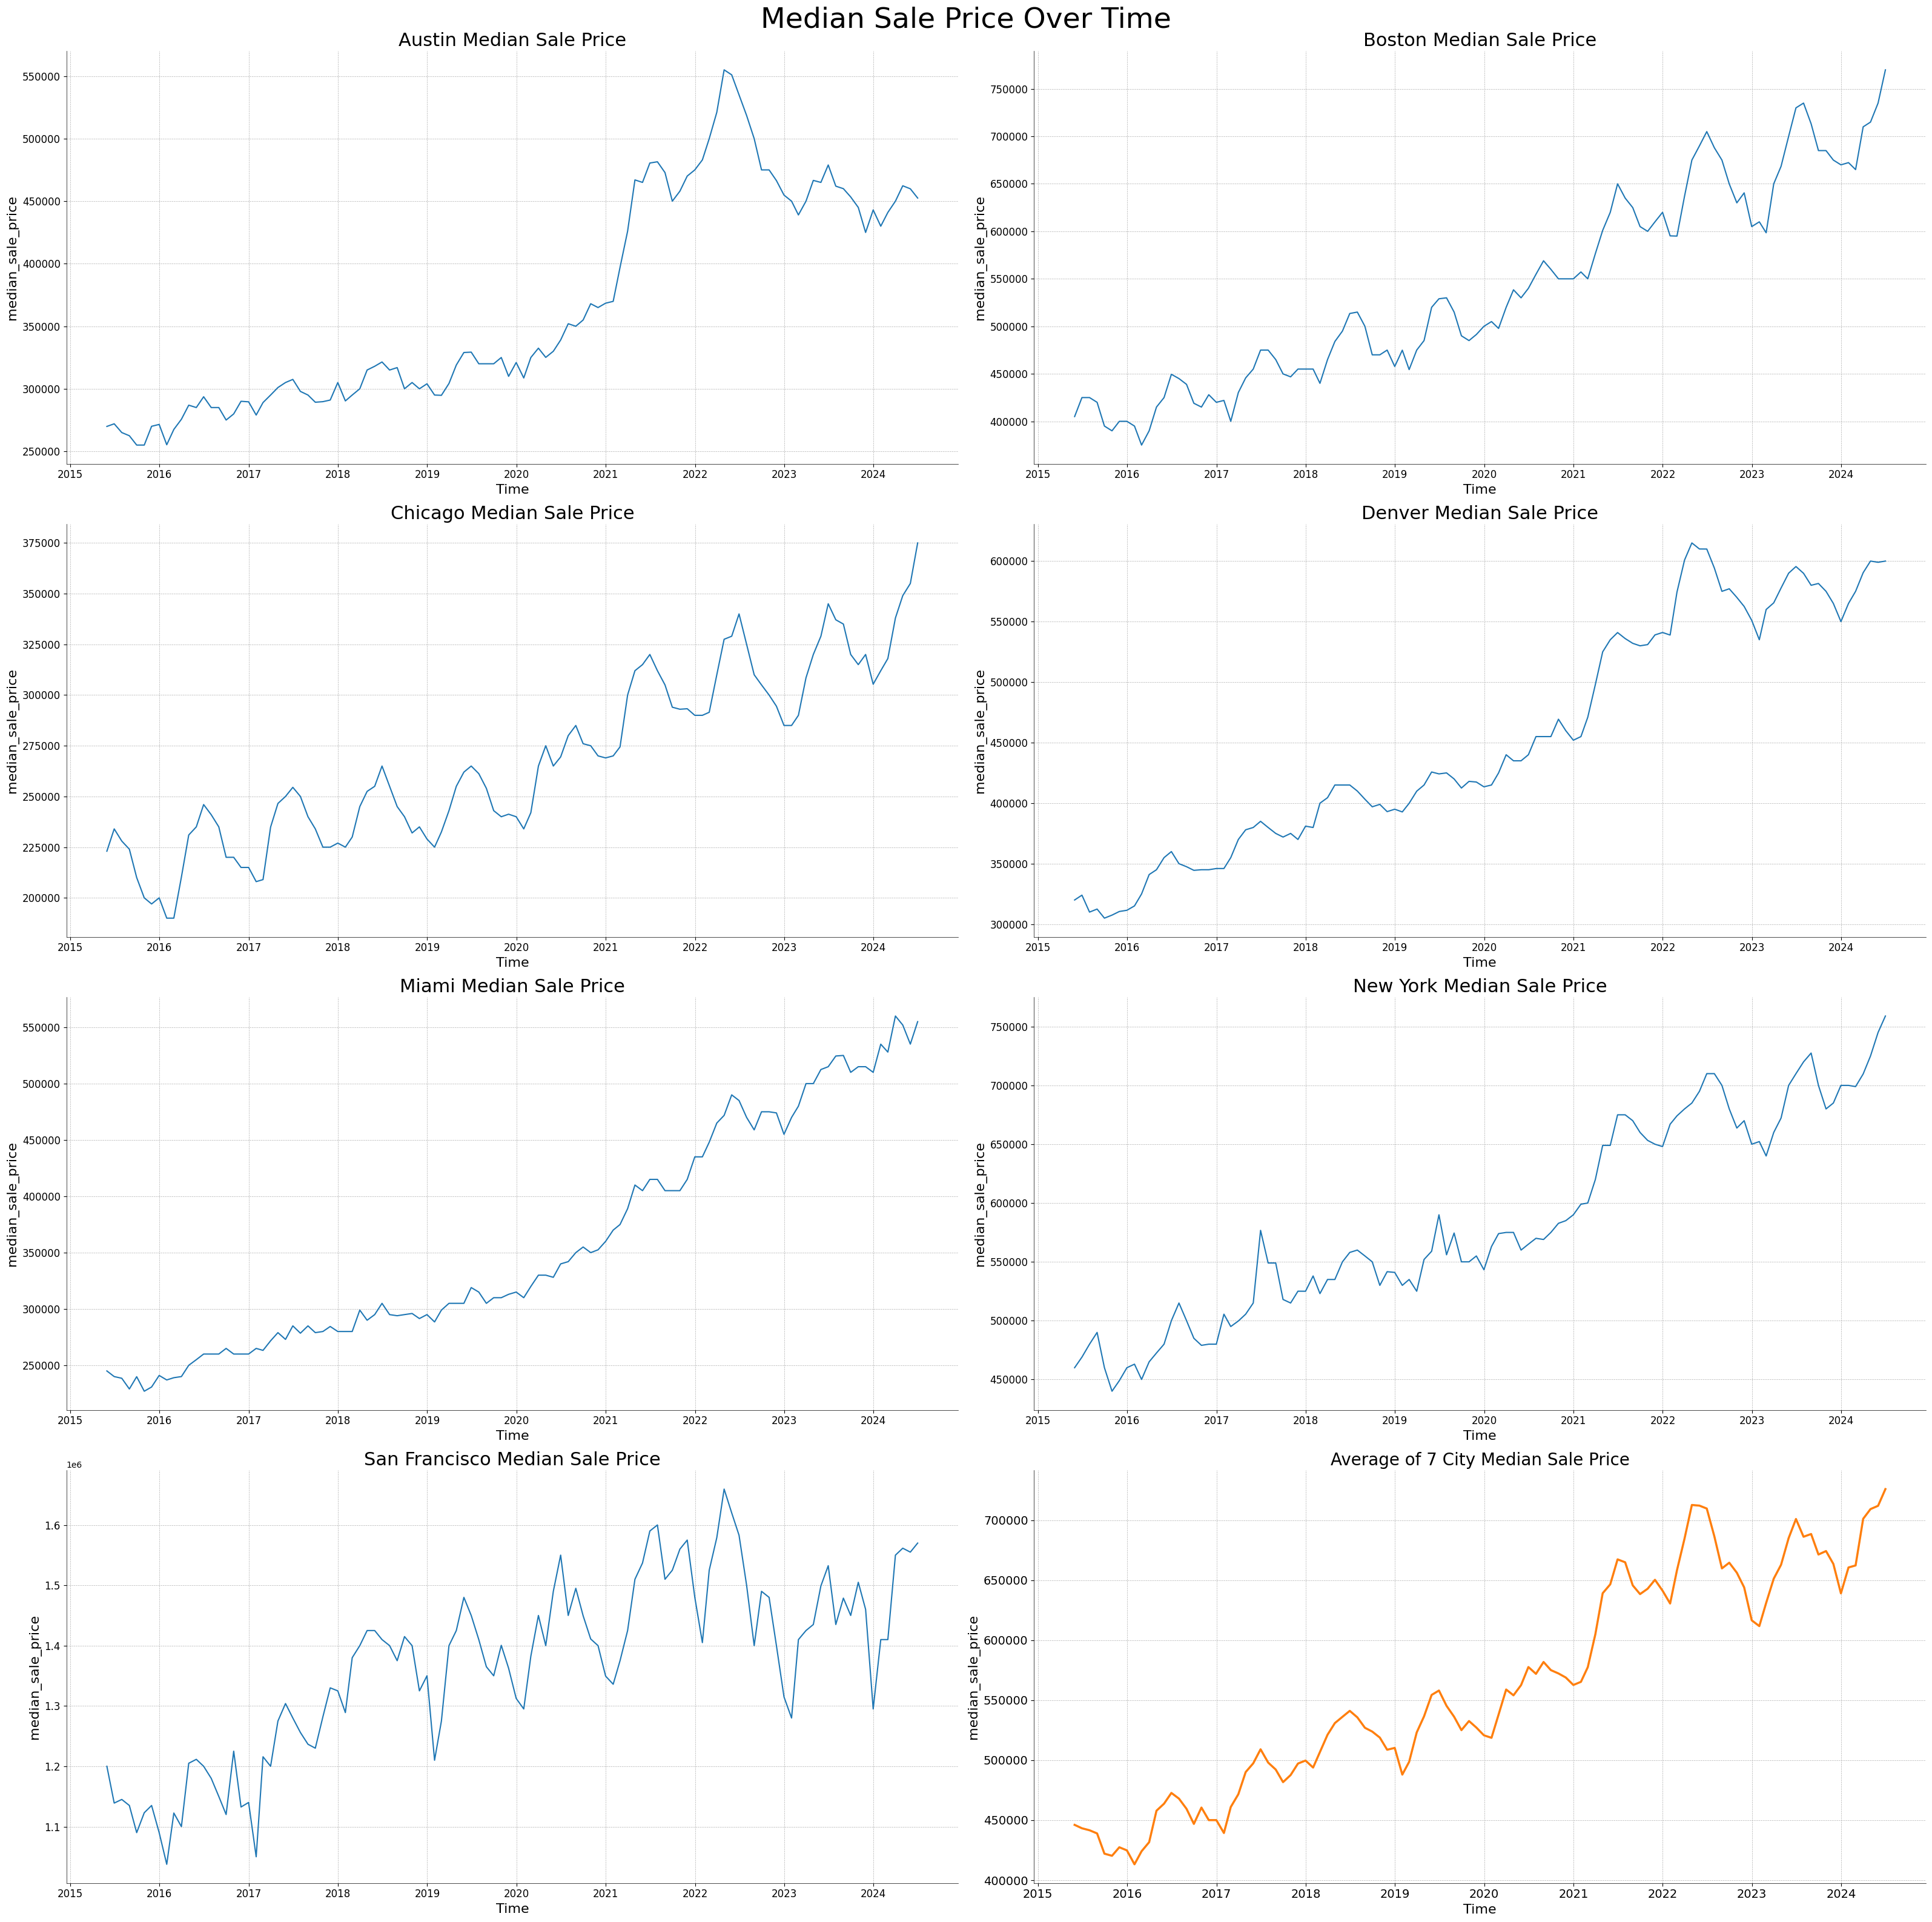

In [13]:
def visualize_median_sale_price(df, column_name, title_suffix):
    """
    Visualize the 'median_sale_price' or 'median_sale_price_diff' column for different cities and an average.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to visualize ('median_sale_price' or 'median_sale_price_diff').
        title_suffix (str): The suffix to add to the plot titles.

    Returns:
        None (displays the plot).
    """
    # Create subplots in a 4x2 grid
    fig, axes = plt.subplots(4, 2, figsize=(32, 32))
    fig.subplots_adjust(hspace=0.8)  # Adjust spacing between subplots and titles

    # List of cities including 'Average of 7 City'
    cities = df['city'].unique()

    # Iterate through cities and create plots
    for i, city in enumerate(cities):

        row = i // 2
        col = i % 2
        ax = axes[row, col]

        # Filter data for the current city
        city_data = df[df['city'] == city]

        # Plot the specified column over time
        ax.plot(city_data['period_end'], city_data[column_name])
        ax.set_title(f'{city} {title_suffix}', fontsize=22)  # Increase title font size
        ax.set_xlabel('Time', fontsize=16)  # Increase x-axis label font size
        ax.set_ylabel(column_name, fontsize=16)  # Increase y-axis label font size
        ax.grid(True, linestyle='--', linewidth=0.5)  # Clean grids with slightly thicker x-axis lines
        ax.tick_params(axis='both', which='both', labelsize=12)  # Increase tick label font size

    # Calculate and plot the 'Average of 7 City'
    general_average = df[df['city'] == 'Average of 7 City']

    # Plot 'Average of 7 City' with a thicker line
    ax = axes[-1, -1]
    ax.plot(general_average['period_end'], general_average[column_name], linewidth=2.5)

    ax.set_title(f'Average of 7 City {title_suffix}', fontsize=20)  # Increase title font size
    ax.set_xlabel('Time', fontsize=16)  # Increase x-axis label font size
    ax.set_ylabel(column_name, fontsize=16)  # Increase y-axis label font size
    ax.grid(True, linestyle='--', linewidth=0.5)  # Clean grids with slightly thicker x-axis lines
    ax.tick_params(axis='both', which='both', labelsize=14)  # Increase tick label font size

    # Remove unnecessary frames
    for ax in axes.ravel():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(0.5)
        ax.spines['left'].set_linewidth(0.5)

    # Add a title for the entire grid and increase font size
    plt.suptitle(f'{title_suffix} Over Time', fontsize=34, y=0.99)


    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()      

# To visualize the 'median_sale_price' column:
visualize_median_sale_price(filtered_df, 'median_sale_price', 'Median Sale Price')

# 1. Stationary Time Series:

A time series is considered stationary if it satisfies the following conditions: 

- a. Constant Mean (μ): The mean of the time series remains constant over time. This can be written as:

μ(t) = μ, where μ is a constant.

- b. Constant Variance (σ²): The variance of the time series also remains constant over time. This can be written as:

σ²(t) = σ², where σ² is a constant.

- c. Constant Autocovariance (or Autocorrelation): The autocovariance or autocorrelation between the time series at different time points remains constant and does not depend on time. This can be written as:

γ(t, t+k) = γ(k), or ρ(t, t+k) = ρ(k),

where γ(t, t+k) is the autocovariance at time t and time t+k, and ρ(t, t+k) is the autocorrelation at time t and time t+k.

# 2. Why Stationarity Matters:

Stationarity is essential in time series analysis for several reasons:

a. Model Simplicity: Stationary time series are easier to model and analyze. Many time series models, such as ARIMA (AutoRegressive Integrated Moving Average), assume stationarity or work best with stationary data.

b. Predictive Accuracy: Stationary time series often exhibit more stable and predictable patterns, making them better candidates for forecasting and prediction. Non-stationary time series can have erratic and unpredictable behavior.

c. Statistical Validity: Many statistical tests and methods, such as hypothesis tests and confidence intervals, assume stationarity. Using non-stationary data with these methods can lead to incorrect or unreliable results.

d. Interpretability: Stationary time series are easier to interpret because their statistical properties remain consistent over time. Changes in mean, variance, or autocorrelation can signal important shifts or trends in the data.

## 3. Checking for Stationarity

To assess the stationarity of a time series data, we can employ the following steps:

1. **Visual Inspection:** Plotting the data and look for any obvious trends or seasonality.

    - Seasonality and mean shifts can be visually identified in the plots. 
    
    <br>

2. **Summary Statistics:** Calculating and comparing the mean and variance of different segments of the data.

3. **Augmented Dickey-Fuller Test (ADF Test):**  Applying the ADF test and check the p-value. A low p-value (p < 0.05) suggests stationarity.

4. **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:**  Using the KPSS test and assess its results. A non-significant result suggests stationarity.

5. **ACF and PACF Plots:** Examining the autocorrelation and partial autocorrelation plots.

<br>

If any of these methods suggest non-stationarity, we should consider applying transformations like differencing or others to make the data stationary for modeling.

- Some common transformations or methods for stationarity or cointegration are differencing, detrending, logging, or using error correction models (ECMs) or vector autoregression models (VARs). <br>

## 4. Performing the ADF(Augmented Dickey-Fuller) Test

- The ADF test is commonly used to check for the presence of a unit root in a time series, which is an indicator of non-stationarity. <br>

- The null hypothesis of the ADF test is that the time series has a unit root (i.e., it is non-stationary). <br>

- If the p-value obtained from the ADF test is less than a chosen significance level (0.05), you can reject the null hypothesis and conclude that the time series is stationary. <br>

- A unit root in time series data means that the data has a stochastic (random) trend and does not exhibit a stable, consistent pattern. In simpler terms, it suggests that the data has not reached a state of equilibrium and tends to wander **unpredictably** over time. When a time series has a unit root, it is considered non-stationary because its statistical properties, such as the mean and variance, are not constant over time. <br>

In [14]:
from statsmodels.tsa.stattools import adfuller

def adf_test_for_column(data, column_name):
    results = []

    # List of unique cities in the dataset
    unique_cities = data['city'].unique()

    # Iterate through cities and apply ADF test
    for city in unique_cities:
        # Filter data for the current city and specified column
        city_data = data[(data['city'] == city)]

        # Extract the specified column as a time series
        time_series = city_data[column_name]

        # Perform the Augmented Dickey-Fuller (ADF) test
        result = adfuller(time_series)

        # Append results to the results list
        results.append({
            'City': city,
            'ADF Statistic': result[0],
            'P-Value': result[1],
            'Critical Values': result[4]
        })
    
    # Convert results list to a DataFrame
    adf_test_df = pd.DataFrame(results)
    return adf_test_df

adf_results = adf_test_for_column(filtered_df, 'median_sale_price')

In [15]:
# # ignore
# from statsmodels.tsa.stattools import adfuller

# def adf_test_for_column(data, column_name):
#     # Create an empty DataFrame to store ADF test results
#     adf_test_df = pd.DataFrame(columns=['City', 'ADF Statistic', 'P-Value', 'Critical Values'])

#     # List of unique cities in the dataset
#     unique_cities = data['city'].unique()

#     # Iterate through cities and apply ADF test
#     for city in unique_cities:
#         # Filter data for the current city and specified column
#         city_data = data[(data['city'] == city)]

#         # Extract the specified column as a time series
#         time_series = city_data[column_name]

#         # Perform the Augmented Dickey-Fuller (ADF) test
#         result = adfuller(time_series)

#         # Append results to the DataFrame
#         adf_test_df = adf_test_df.append({
#             'City': city,
#             'ADF Statistic': result[0],
#             'P-Value': result[1],
#             'Critical Values': result[4]
#         }, ignore_index=True)
    
#     return adf_test_df

# adf_results = adf_test_for_column(filtered_df, 'median_sale_price')

In [16]:
pd.set_option('display.max_colwidth', None)
adf_results

City  ADF Statistic   P-Value  \
0             Austin      -1.676304  0.443361   
1             Boston       0.807599  0.991758   
2            Chicago       0.443219  0.983041   
3             Denver      -0.892233  0.790519   
4              Miami       2.158968  0.998847   
5           New York      -0.004812  0.958132   
6      San Francisco      -1.803102  0.378923   
7  Average of 7 City      -0.739466  0.836261   

                                                                      Critical Values  
0  {'1%': -3.4996365338407074, '5%': -2.8918307730370025, '10%': -2.5829283377617176}  
1  {'1%': -3.4996365338407074, '5%': -2.8918307730370025, '10%': -2.5829283377617176}  
2  {'1%': -3.4996365338407074, '5%': -2.8918307730370025, '10%': -2.5829283377617176}  
3  {'1%': -3.4996365338407074, '5%': -2.8918307730370025, '10%': -2.5829283377617176}  
4  {'1%': -3.4968181663902103, '5%': -2.8906107514600103, '10%': -2.5822770483285953}  
5  {'1%': -3.4968181663902103, '5%': -2.8906107514600103, '10%': -2.5822770483285953}  
6  {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}  
7  {'1%': -3.4996365338407074, '5%': -2.8918307730370025, '10%': -2.5829283377617176}

 - The ADF test results indicate that the median sale prices in all analyzed cities are not stationary. This conclusion is drawn from the high p-values obtained for each city, which fail to reject the null hypothesis of non-stationarity at common significance levels. <br>

- To consider a time series as stationary, you typically want the p-value to be below the chosen significance level, which is not the case here. <br>

In [17]:
# Apply differencing to the 'median_sale_price' column
filtered_df['median_sale_price_diff'] = filtered_df.groupby('city')['median_sale_price'].diff()

# Drop NaN values resulting from differencing
filtered_df = filtered_df.dropna()

filtered_df.head()

period_begin period_end    city    property_type  median_sale_price  \
1   2015-06-01 2015-06-30  Austin  All Residential           272000.0   
2   2015-07-01 2015-07-31  Austin  All Residential           265000.0   
3   2015-08-01 2015-08-31  Austin  All Residential           262461.0   
4   2015-09-01 2015-09-30  Austin  All Residential           255000.0   
5   2015-10-01 2015-10-31  Austin  All Residential           255000.0   

   median_sale_price_diff  
1                  2100.0  
2                 -7000.0  
3                 -2539.0  
4                 -7461.0  
5                     0.0

###  Using the Augmented Dickey-Fuller test (ADF test) to check for stationarity in the data after differencing.

In [18]:
adf_results_differenced = adf_test_for_column(filtered_df, 'median_sale_price_diff')

- Observe the decreasing p-values, indicating that the data has become "more" stationary. <br>
- It's essential to consider both the ADF statistic and the p-value together. A highly negative ADF statistic but a high p-value might still suggest non-stationarity due to a small sample size or other factors. 

In [19]:
# notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)
adf_results_differenced.sort_values('ADF Statistic')

City  ADF Statistic  P-Value  \
5           New York       -6.19278  0.00000   
1             Boston       -3.30910  0.01448   
6      San Francisco       -2.51159  0.11268   
2            Chicago       -2.44882  0.12843   
7  Average of 7 City       -2.31904  0.16590   
4              Miami       -2.16557  0.21898   
3             Denver       -1.78225  0.38931   
0             Austin       -1.47303  0.54681   

                                                                      Critical Values  
5  {'1%': -3.4968181663902103, '5%': -2.8906107514600103, '10%': -2.5822770483285953}  
1  {'1%': -3.4996365338407074, '5%': -2.8918307730370025, '10%': -2.5829283377617176}  
6  {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}  
2  {'1%': -3.4996365338407074, '5%': -2.8918307730370025, '10%': -2.5829283377617176}  
7  {'1%': -3.4996365338407074, '5%': -2.8918307730370025, '10%': -2.5829283377617176}  
4  {'1%': -3.4996365338407074, '5%': -2.8918307730370025, '10%': -2.5829283377617176}  
3  {'1%': -3.4996365338407074, '5%': -2.8918307730370025, '10%': -2.5829283377617176}  
0  {'1%': -3.4996365338407074, '5%': -2.8918307730370025, '10%': -2.5829283377617176}

In [20]:
# Create a DataFrame containing only the selected cities
subset_df = filtered_df

# Calculate first-order difference for each city's 'median_sale_price'
subset_df['median_sale_price_diff'] = subset_df.groupby('city')['median_sale_price'].diff()

# Calculate second-order difference for each city's 'median_sale_price_diff'
subset_df['median_sale_price_diff2'] = subset_df.groupby('city')['median_sale_price_diff'].diff()

# Drop NaN values resulting from differencing
subset_df = subset_df.dropna()

# Perform ADF test on 'median_sale_price_diff2' for the selected cities
adf_results_differenced2 = adf_test_for_column(subset_df, 'median_sale_price_diff2')

In [21]:
adf_results_differenced2

City  ADF Statistic  P-Value  \
0             Austin       -3.14867  0.02315   
1             Boston       -7.34869  0.00000   
2            Chicago       -7.43383  0.00000   
3             Denver       -9.20371  0.00000   
4              Miami       -7.93075  0.00000   
5           New York       -7.46996  0.00000   
6      San Francisco       -8.31389  0.00000   
7  Average of 7 City       -9.93883  0.00000   

                                                                      Critical Values  
0    {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}  
1    {'1%': -3.502704609582561, '5%': -2.8931578098779522, '10%': -2.583636712914788}  
2    {'1%': -3.5019123847798657, '5%': -2.892815255482889, '10%': -2.583453861475781}  
3  {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}  
4  {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}  
5  {'1%': -3.5011373281819504, '5%': -2.8924800524857854, '10%': -2.5832749307479226}  
6  {'1%': -3.5011373281819504, '5%': -2.8924800524857854, '10%': -2.5832749307479226}  
7  {'1%': -3.5003788874873405, '5%': -2.8921519665075235, '10%': -2.5830997960069446}

## 5. Differencing Visualizations Explanation:

The code creates a grid of subplots, where each row corresponds to a different city, and each row contains three plots:

5.1 **Median Sale Price**: The leftmost plot in each row shows the original median sale prices over time for a specific city. This plot provides insights into the general trend and seasonality in the housing market.

5.2 **Median Sale Price Diff**: The middle plot in each row displays the first-order differencing of median sale prices. This means it shows the changes (differences) between consecutive time points. Using differencing helps remove trends and seasonality, making underlying patterns, such as stationarity or unusual spikes, more visible.

5.3 **Median Sale Price Diff (2nd Order)**: The rightmost plot in each row presents the second-order differencing of median sale prices. This is the difference between consecutive values of the first-order differenced data. Second-order differencing is used for further simplification and potential experimentation in identifying patterns.

## 6. Interpretation of Price Differentiation Plots:

6.1 - **Median Sale Price**: This plot can reveal long-term trends and seasonal patterns. An upward or downward trend may suggest a city's real estate market is generally appreciating or depreciating over time.

6.2 - **Median Sale Price Diff**: Differencing helps in making the data stationary, which is often a prerequisite for time series modeling like ARIMA. Sudden spikes or unusual patterns in this plot might indicate specific events or outliers that need attention.

6.3 - **Median Sale Price Diff (2nd Order)**: Second-order differencing is used when the first-order differenced data still contains trends. If this plot exhibits a relatively stable pattern around zero, it suggests that first-order differencing is sufficient.

## 7. Why First-Order Differencing:

First-order differencing is commonly used because it often removes the most prominent trends and seasonality, making the data stationary. Stationary data simplifies modeling and improves forecasting accuracy. However, if first-order differencing doesn't achieve stationarity or if further experimentation is needed, second-order differencing or other transformations can be explored.

These visualizations serve as a foundational step in understanding the characteristics of the data before proceeding with time series modeling.

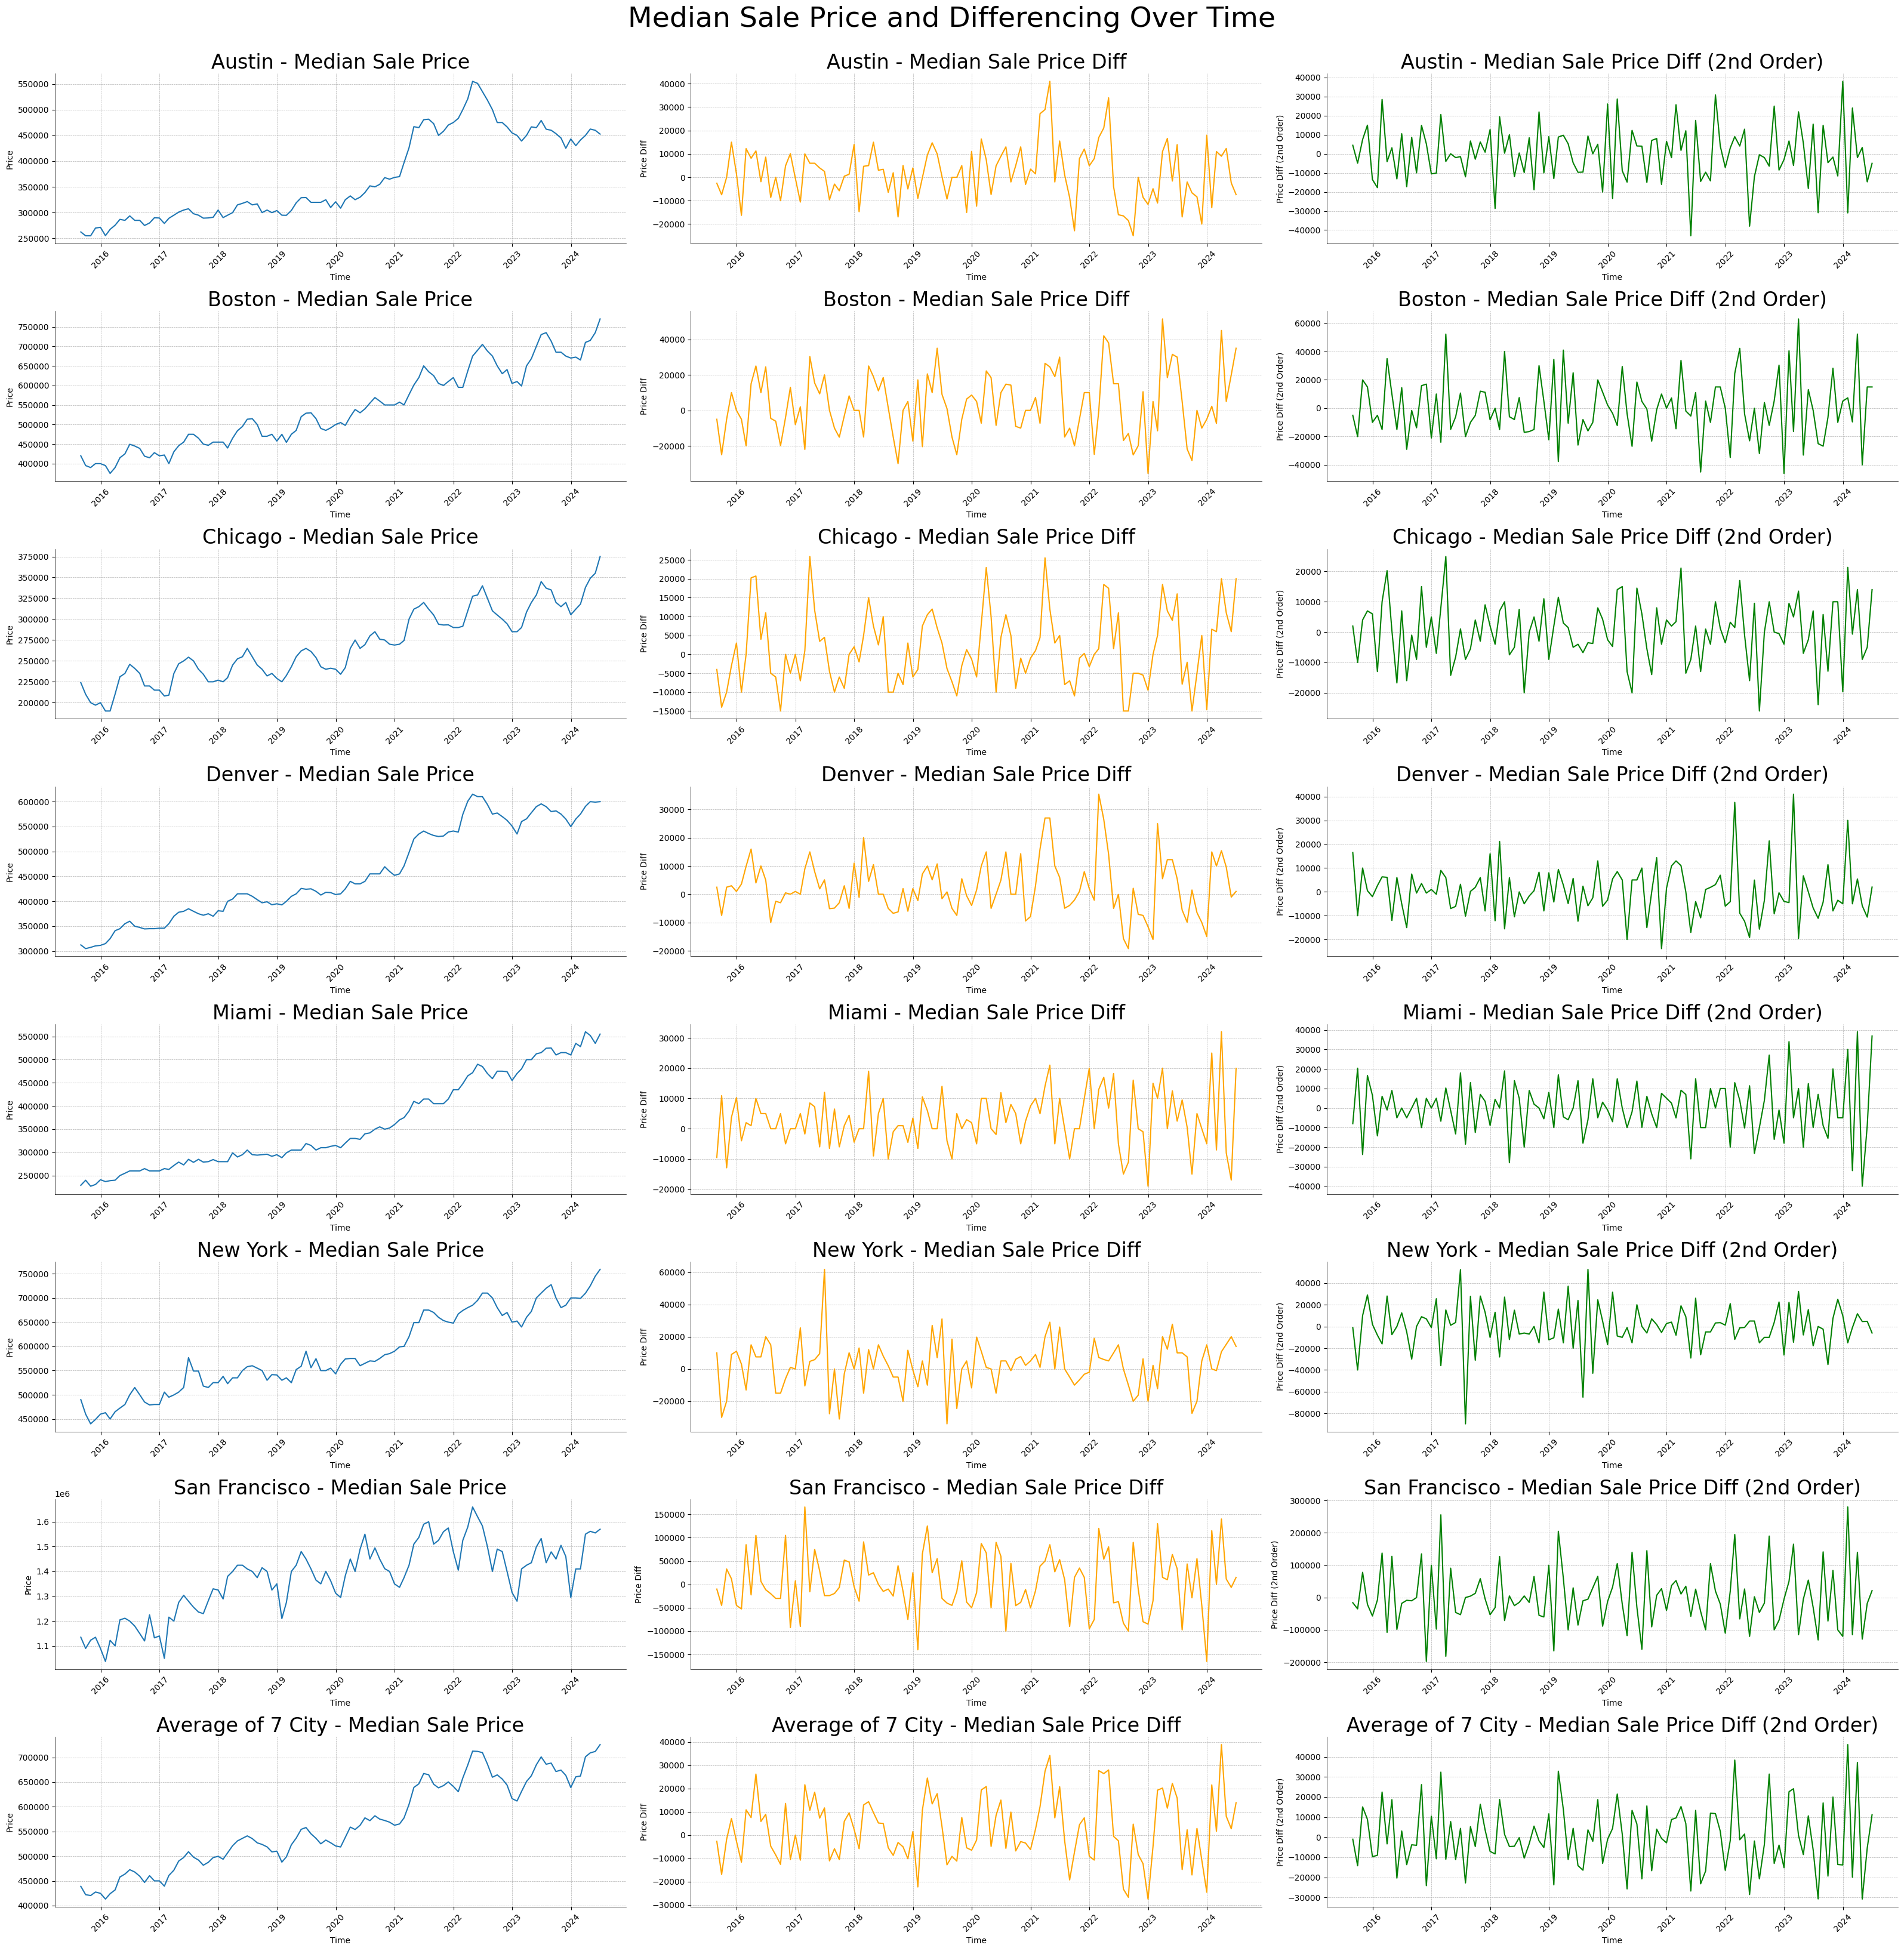

In [22]:
import matplotlib.pyplot as plt

def plot_median_prices(df, figsize=(32, 32)):
    # List of cities to plot
    cities_to_plot = df['city'].unique()

    # Determine the number of rows based on the number of unique cities
    num_rows = len(cities_to_plot)

    # Create subplots in a num_rows x 3 grid
    fig, axes = plt.subplots(num_rows, 3, figsize=figsize)
    fig.subplots_adjust(hspace=0.5)  # Adjust spacing between subplots

    # Iterate through cities and create plots
    for i, city in enumerate(cities_to_plot):
        row = i  # Row index
        col = 0   # Column index for 'median_sale_price'
        
        # Filter data for the current city
        city_data = subset_df[subset_df['city'] == city]
        
        # Plot 'median_sale_price'
        axes[row, col].plot(city_data['period_end'], city_data['median_sale_price'])
        axes[row, col].set_title(f'{city} - Median Sale Price', fontsize=24) 
        axes[row, col].set_xlabel('Time')
        axes[row, col].set_ylabel('Price')
        axes[row, col].grid(True, linestyle='--', linewidth=0.5)
        axes[row, col].tick_params(axis='x', rotation=45)
        
        col = 1   # Column index for 'median_sale_price_diff'
        
        # Plot 'median_sale_price_diff'
        axes[row, col].plot(city_data['period_end'], city_data['median_sale_price_diff'], color='orange')
        axes[row, col].set_title(f'{city} - Median Sale Price Diff', fontsize=24) 
        axes[row, col].set_xlabel('Time')
        axes[row, col].set_ylabel('Price Diff')
        axes[row, col].grid(True, linestyle='--', linewidth=0.5)
        axes[row, col].tick_params(axis='x', rotation=45)
        
        col = 2   # Column index for 'median_sale_price_diff2'
        
        # Plot 'median_sale_price_diff2'
        axes[row, col].plot(city_data['period_end'], city_data['median_sale_price_diff2'], color='green')
        axes[row, col].set_title(f'{city} - Median Sale Price Diff (2nd Order)', fontsize=24) 
        axes[row, col].set_xlabel('Time')
        axes[row, col].set_ylabel('Price Diff (2nd Order)')
        axes[row, col].grid(True, linestyle='--', linewidth=0.5)
        axes[row, col].tick_params(axis='x', rotation=45)

    # Remove unnecessary frames
    for ax in axes.ravel():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['bottom'].set_linewidth(0.5)


    # Spacing between subplots
    plt.tight_layout()

    # Add a general title
    plt.suptitle('Median Sale Price and Differencing Over Time', fontsize=34, y=1.02)

    # Show the plot
    plt.show()

plot_median_prices(subset_df)

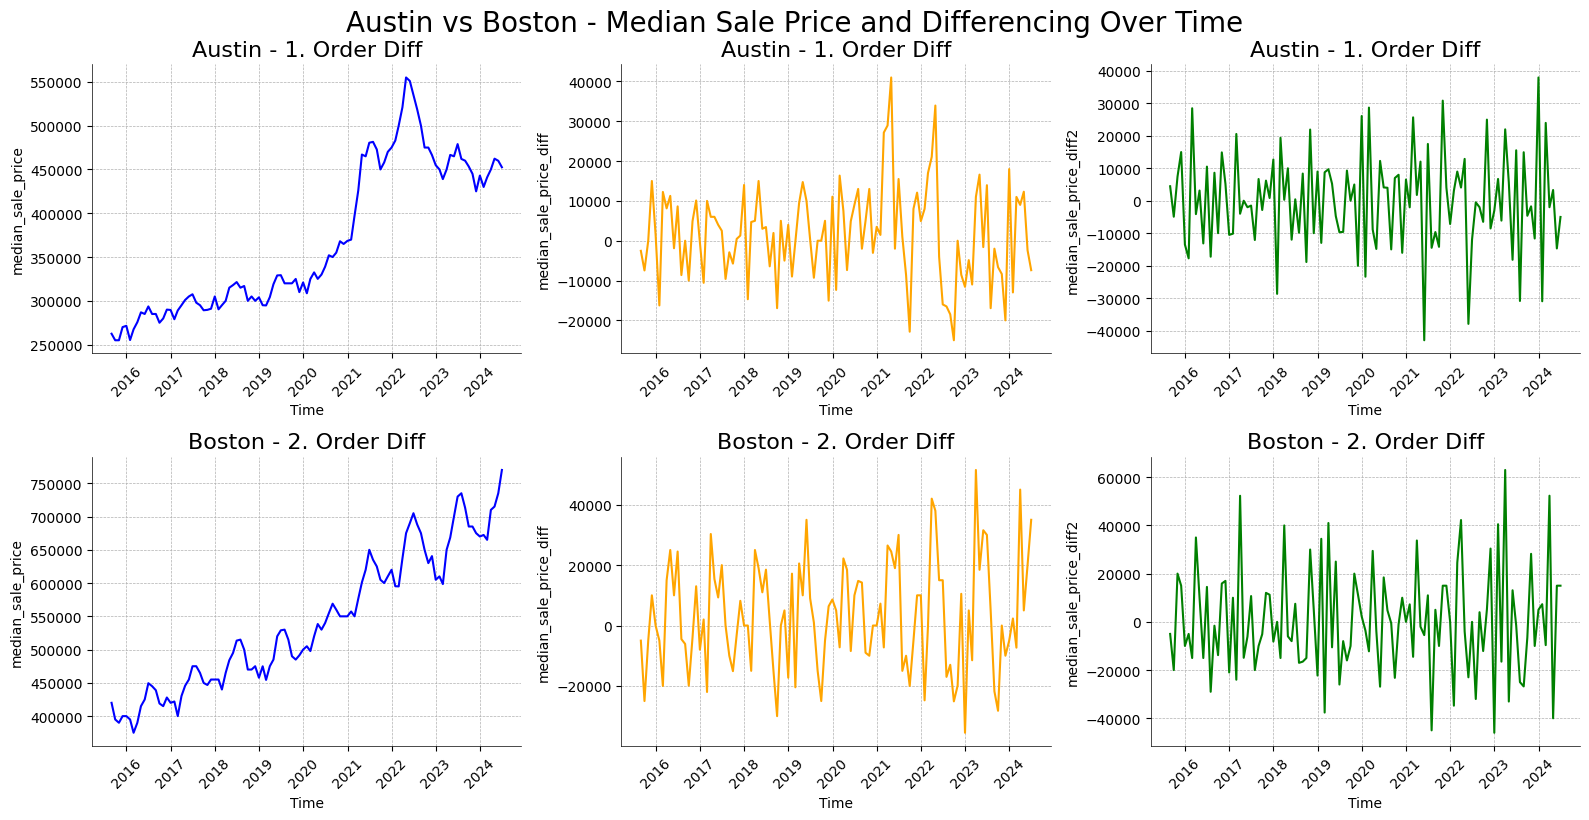

In [23]:
def plot_median_prices_2_cities(df, city1, city2, figsize=(16, 8)):
    # Filter data for the specified cities
    city1_data = df[df['city'] == city1]
    city2_data = df[df['city'] == city2]

    # Create subplots in a 2x3 grid
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.subplots_adjust(hspace=0.5)  # Adjust spacing between subplots

    # Define the columns to plot
    columns_to_plot = ['median_sale_price', 'median_sale_price_diff', 'median_sale_price_diff2']

    # Iterate through columns and create plots
    for i, column in enumerate(columns_to_plot):
        col = i  # Column index
        
        # Choose line color based on the column index
        line_color = 'blue' if col == 0 else ('orange' if col == 1 else 'green')

        # Plot 'median_sale_price' for city1
        axes[0, col].plot(city1_data['period_end'], city1_data[column], color=line_color)
        axes[0, col].set_title(f'{city1} - 1. Order Diff', fontsize=16, fontweight='normal')
        axes[0, col].set_xlabel('Time')
        axes[0, col].set_ylabel(column)
        axes[0, col].grid(True, linestyle='--', linewidth=0.5)
        axes[0, col].tick_params(axis='x', rotation=45)

        # Plot 'median_sale_price' for city2
        axes[1, col].plot(city2_data['period_end'], city2_data[column], color=line_color)
        axes[1, col].set_title(f'{city2} - 2. Order Diff', fontsize=16, fontweight='normal')
        axes[1, col].set_xlabel('Time')
        axes[1, col].set_ylabel(column)
        axes[1, col].grid(True, linestyle='--', linewidth=0.5)
        axes[1, col].tick_params(axis='x', rotation=45)

    # Remove unnecessary frames
    for ax in axes.ravel():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['bottom'].set_linewidth(0.5)

    # Spacing between subplots
    plt.tight_layout()

    # Add a general title
    plt.suptitle(f'{city1} vs {city2} - Median Sale Price and Differencing Over Time', fontsize=20, y=1.02, fontweight='normal')

    # Show the plot
    return plt

# Example usage:
city1_name = 'Austin'
city2_name = 'Boston'
plot_median_prices_2_cities(subset_df, city1_name, city2_name).savefig('median_sale_price_diff.png', dpi=300, bbox_inches='tight')

In [24]:
# Save the figure with one line of code
plt.savefig('median_sale_price_plots.png', format='png', bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

**8. ACF (Autocorrelation Function)** and **PACF (Partial Autocorrelation Function)**  :
 The ACF and PACF are essential tools employed in time series analysis to understand and model temporal dependencies within the data.

- **8.1 ACF (Autocorrelation Function):** ACF measures the linear relationship between an observation in a time series and its past observations at various lags. It quantifies how each lagged value is correlated with the current value. 

  - **8.1.1 Effect on Model Parameters:** ACF helps determine the order of the Moving Average (MA) component in models like ARIMA. Peaks or significant correlations at certain lags indicate the potential order of the MA term. For example, if there is a significant spike at lag 1 in the ACF plot, it suggests that the first-order MA term (q) may be appropriate for the model.
  
  <br>

- **8.2 PACF (Partial Autocorrelation Function):** PACF measures the direct relationship between an observation and its lagged values, while controlling for the influence of shorter lags. It shows the unique contribution of each lag to the current observation.

  - **8.2.1 Effect on Model Parameters:** PACF helps determine the order of the AutoRegressive (AR) component in models like ARIMA. Sharp drops or significant spikes in PACF at certain lags indicate the potential order of the AR term. For example, if there is a sharp drop after lag 1 in the PACF plot, it suggests that the first-order AR term (p) may be appropriate for the model.

**9 Interpretation of Visualizations of ACF and PACF**

- **9.1 ACF:** Peaks at certain lags indicate potential MA (Moving Average) orders (q). If ACF shows a significant peak at lag 2, it suggests a second-order MA term (q=2). A gradual decay suggests a higher-order ARIMA model may not be necessary.

- **9.2 PACF:** Sharp drops or peaks at certain lags indicate potential AR orders (p). If PACF shows a sharp drop after lag 1, it suggests a first-order AR term (p=1). Significant spikes beyond a certain lag suggest further AR terms.
<br>
-  Mostly eliminated the spikes in the ACF plot by differencing, it's a positive sign as it indicates that differencing has reduced the autocorrelation in the data, making it more amenable to modeling. <br>
<br>
-  In summary, ACF and PACF plots helps us to identify the presence of autocorrelation and partial autocorrelation in the time series data. These patterns can guide us in selecting appropriate orders for autoregressive (p) and moving average (q) components when fitting ARIMA or SARIMA models. <br>

In [25]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf_for_cities(data, columns, plot_type, lags=12):
    unique_cities = data['city'].unique()
    num_columns = len(columns)

    # Create subplots for each city and column
    fig, axes = plt.subplots(len(unique_cities), num_columns, figsize=(18, 5 * len(unique_cities)))

    for i, city in enumerate(unique_cities):
        city_data = data[data['city'] == city]

        for j, column in enumerate(columns):
            ax = axes[i, j]

            # Plot ACF or PACF based on the plot_type parameter
            if plot_type == 'acf':
                plot_acf(city_data[column], lags=lags, ax=ax)
                ax.set_title(f'{city} - ACF - {column}')
            elif plot_type == 'pacf':
                plot_pacf(city_data[column], lags=lags, ax=ax)
                ax.set_title(f'{city} - PACF - {column}')

            ax.set_xlabel('Lags')
            ax.set_ylabel('Autocorrelation' if plot_type == 'acf' else 'Partial Autocorrelation')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Usage:
columns_to_plot = ['median_sale_price', 'median_sale_price_diff', 'median_sale_price_diff2']

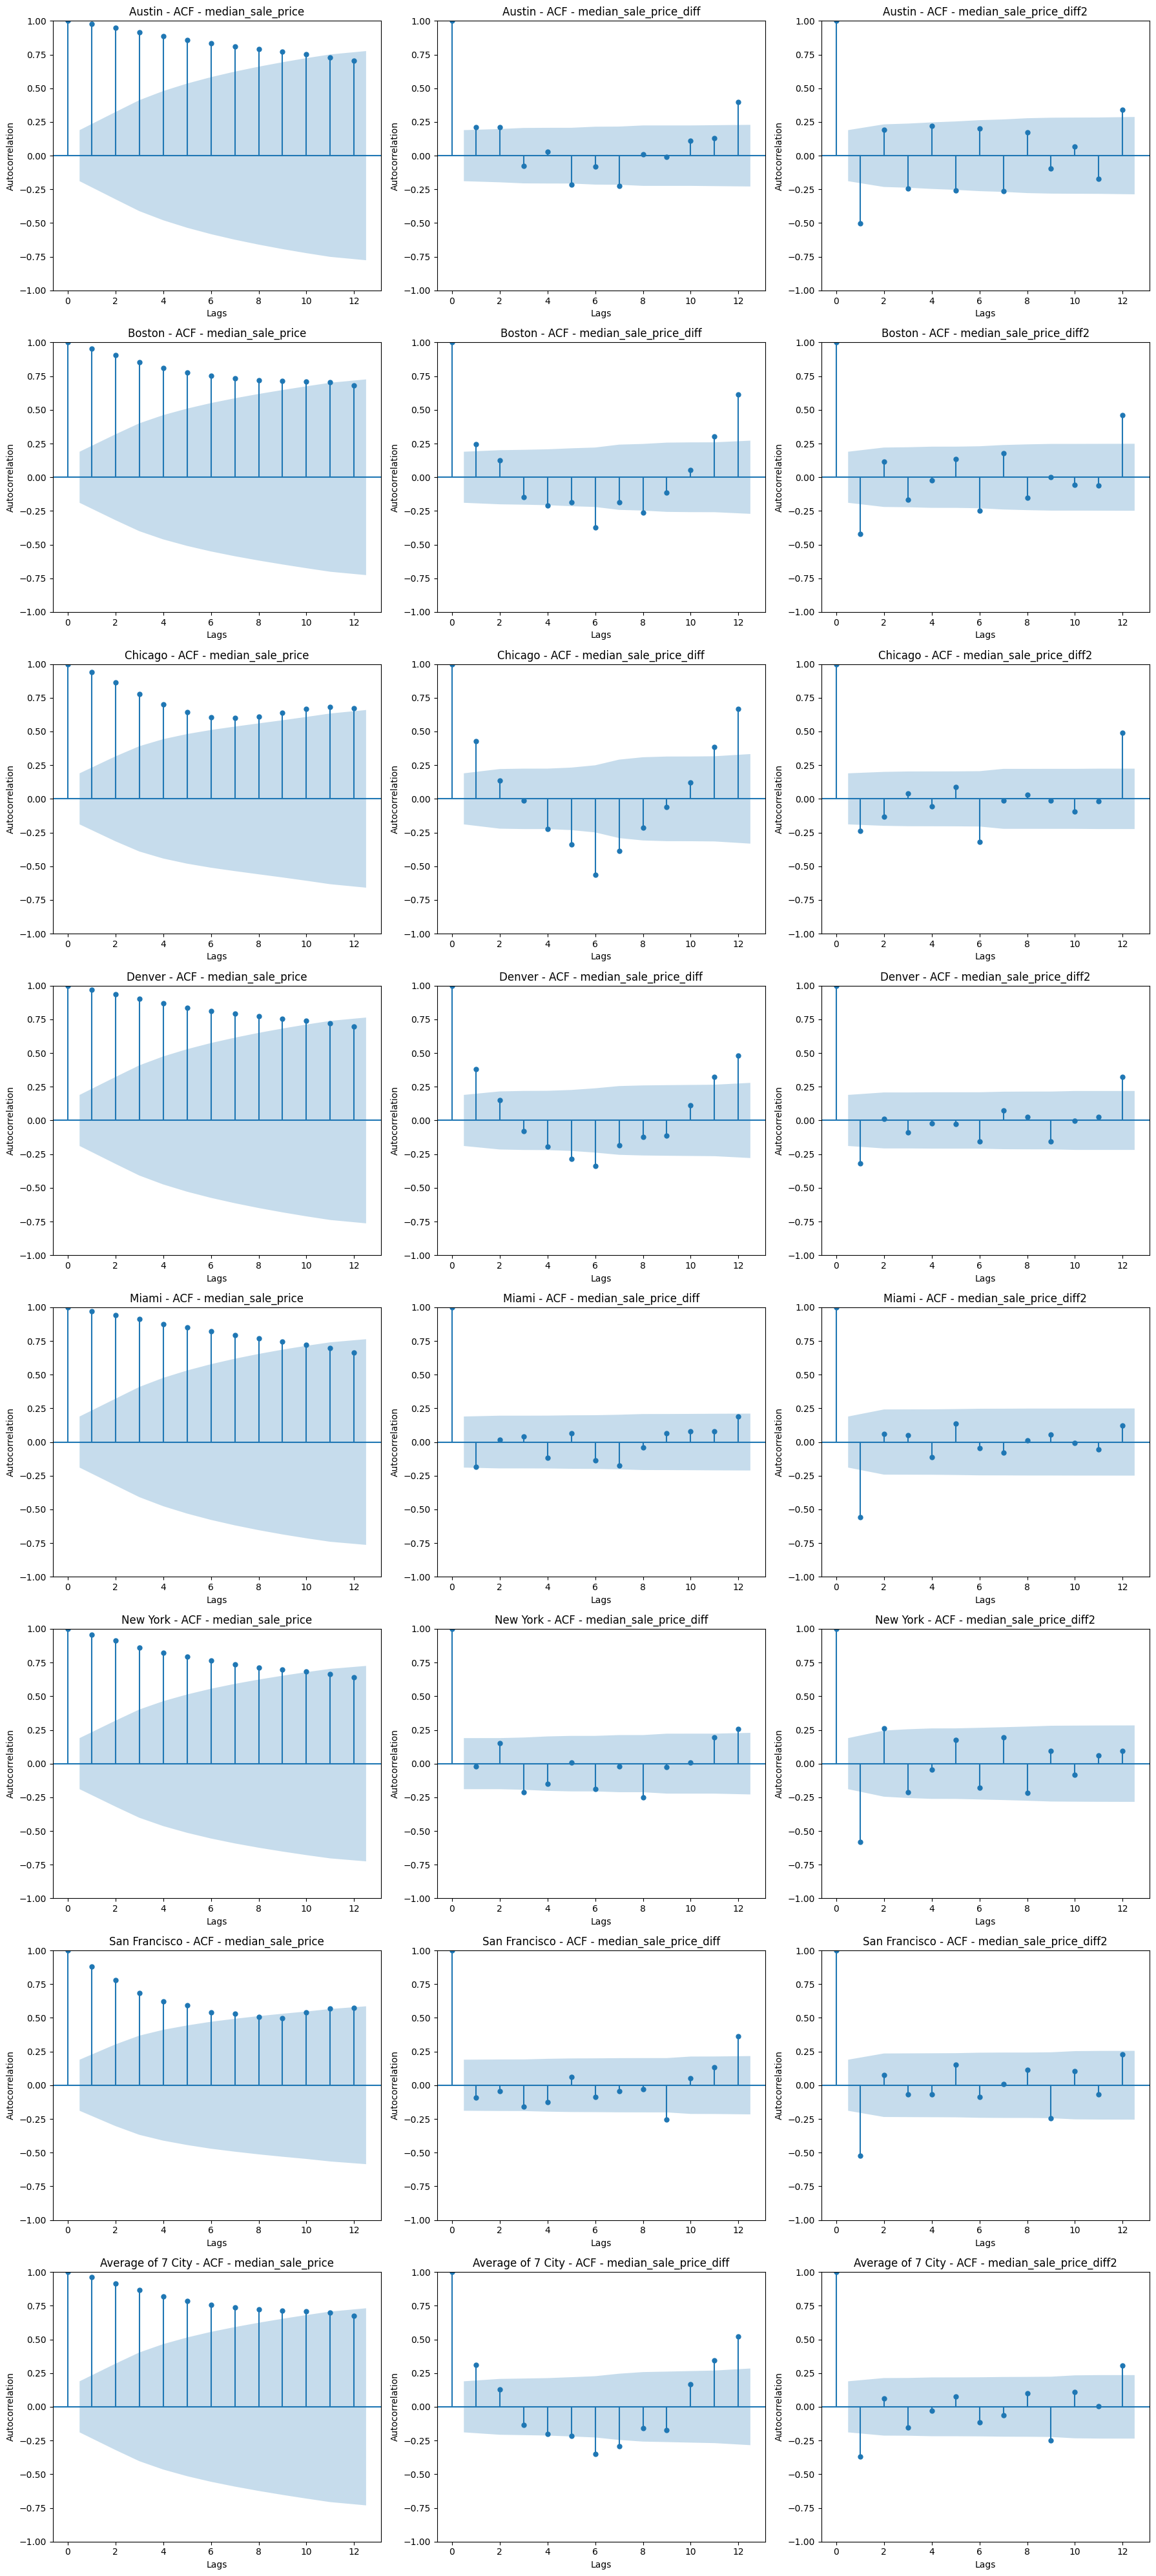

In [26]:
plot_acf_pacf_for_cities(subset_df, columns_to_plot, plot_type='acf', lags=12)

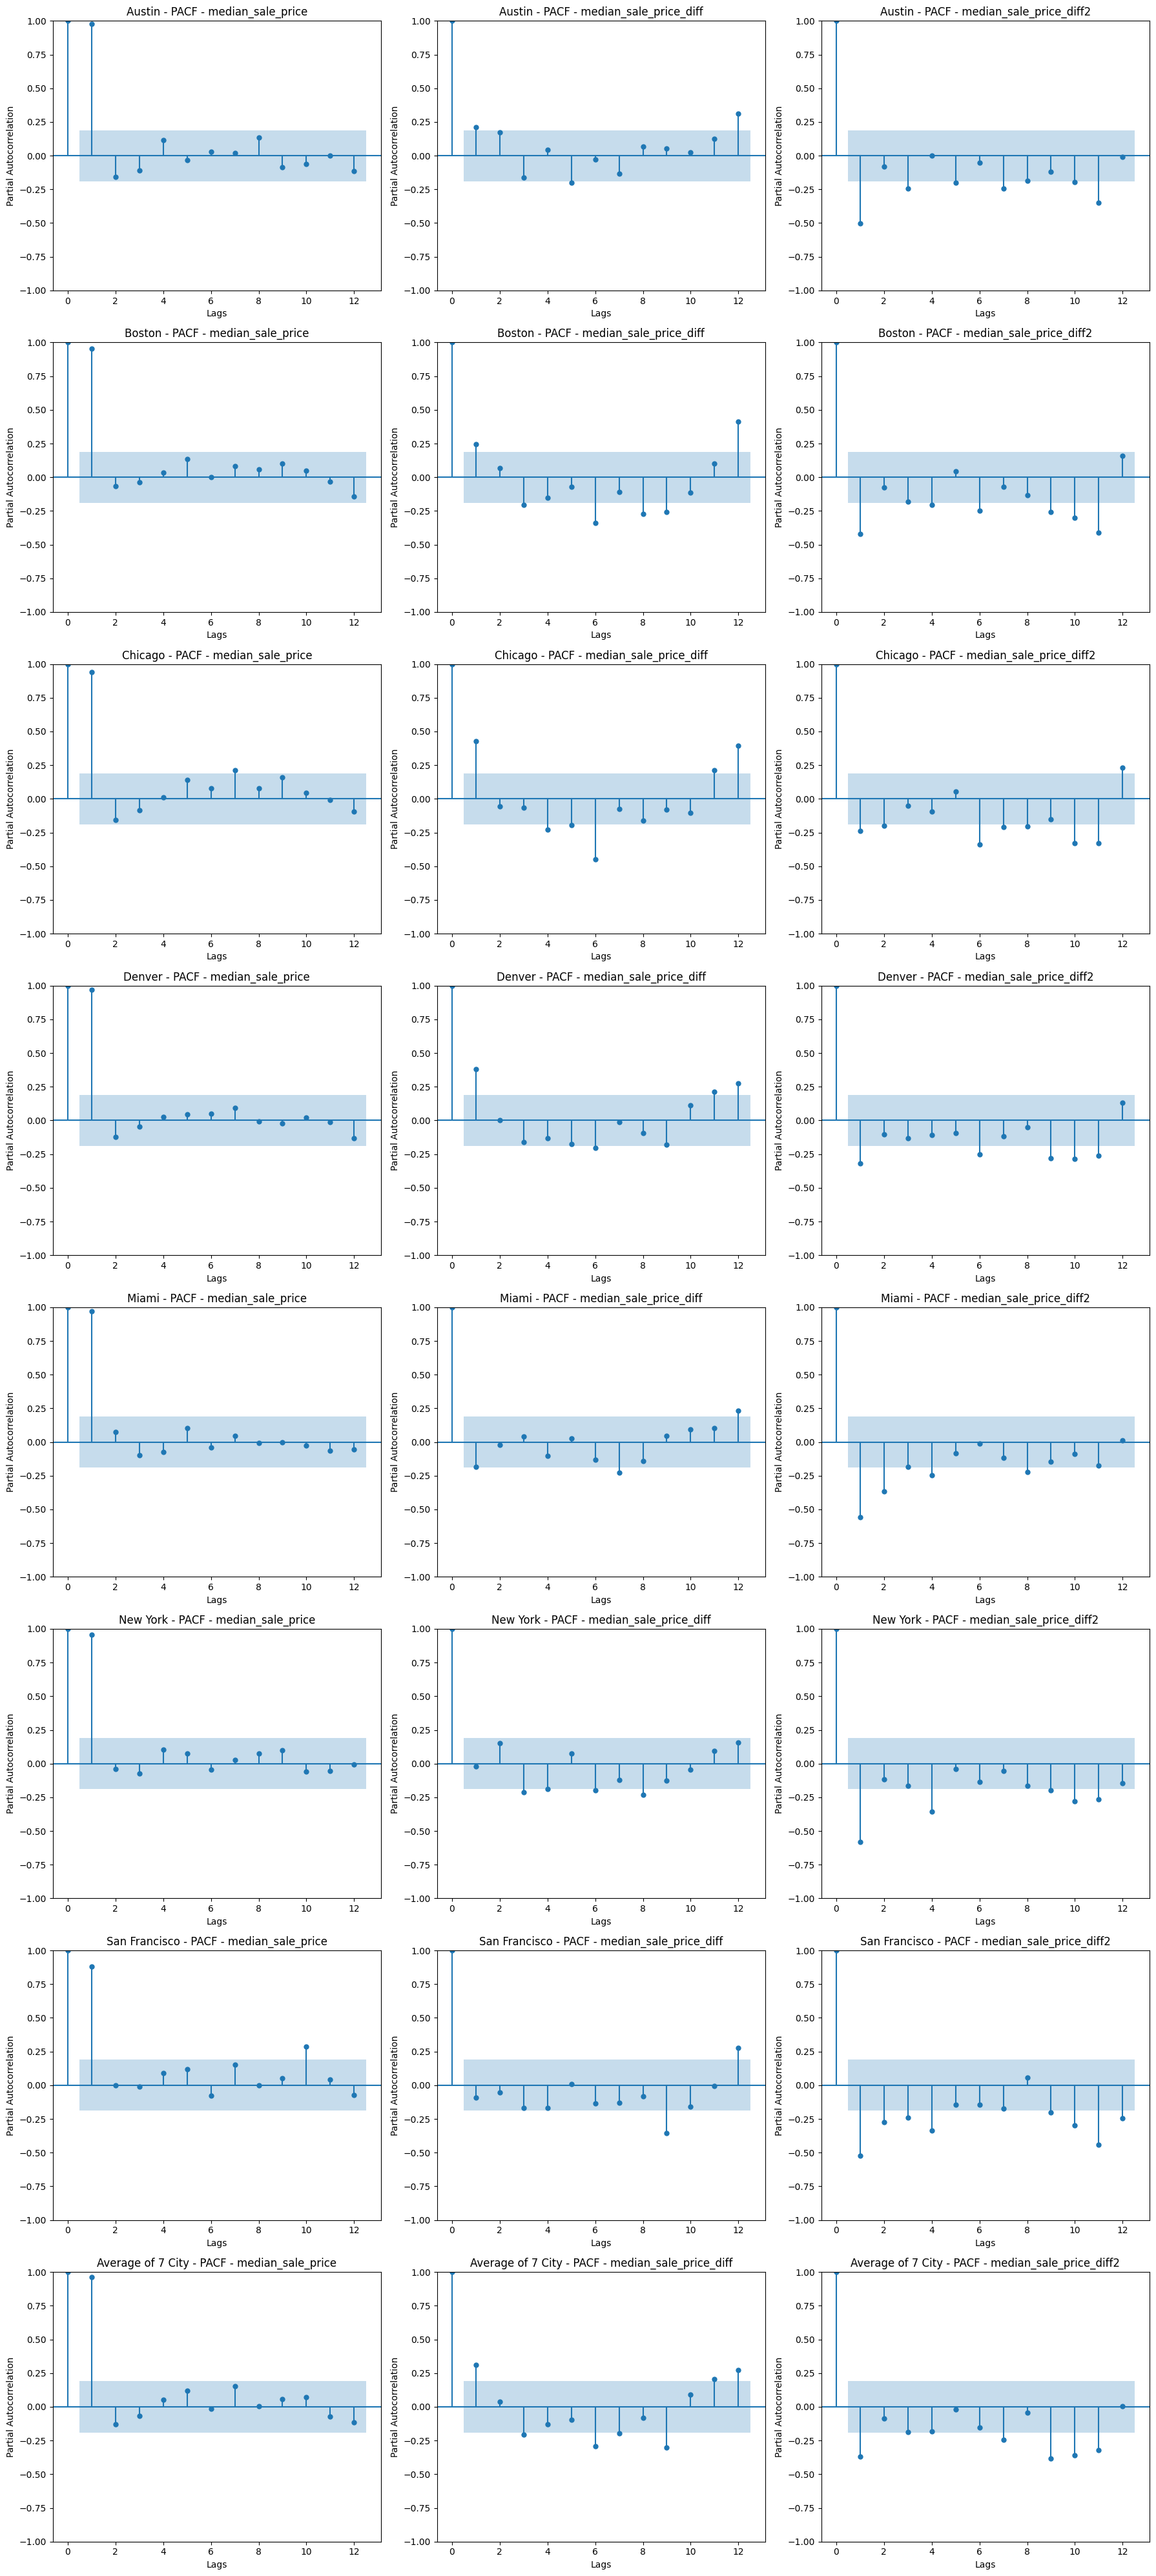

In [27]:
plot_acf_pacf_for_cities(subset_df, columns_to_plot, plot_type='pacf', lags=12)

## 10. Explanation of ADF Statistic and P-Value Comparison Plot

The plot visualizes the Augmented Dickey-Fuller (ADF) statistic and P-values for the original and differenced time series data across different cities. 

### 11. Interpretation of Comparison Plot:

- **11.1 ADF Statistic (Original):** The blue line represents the ADF statistic for the original time series data. It measures the stationarity of the data. If the ADF statistic is less negative (closer to zero), it suggests that the original data is non-stationary and contains a unit root.

- **11.2 ADF Statistic (Differenced):** The red line represents the ADF statistic for the differenced time series data. We applied differencing to transform non-stationary data into stationary data. The red line shows how differencing affects the stationarity of the data.

- **11.3 P-Value (Original and Differenced):** The green and purple lines represent the P-values corresponding to the ADF statistics for the original and differenced data, respectively. The P-value indicates the significance of the ADF statistic. A lower P-value (below a significance level, often 0.05) suggests that the data is stationary.

### 12. Effect of Differencing on P-Values:

- Differencing generally reduces the P-values, making it more likely to reject the null hypothesis of non-stationarity. This means that differencing can help make non-stationary data more stationary, which is often a prerequisite for time series modeling.

- In the plot, significant P-values (P > 0.05) are marked with orange stars for the original data. As we can see, some cities have significant P-values in the original data, indicating non-stationarity. However, after differencing, the P-values for these cities become non-significant (under 0.05), suggesting that differencing has made the data more stationary.

This plot provides insights into the impact of differencing on the stationarity of time series data, making it more suitable for time series analysis and modeling.

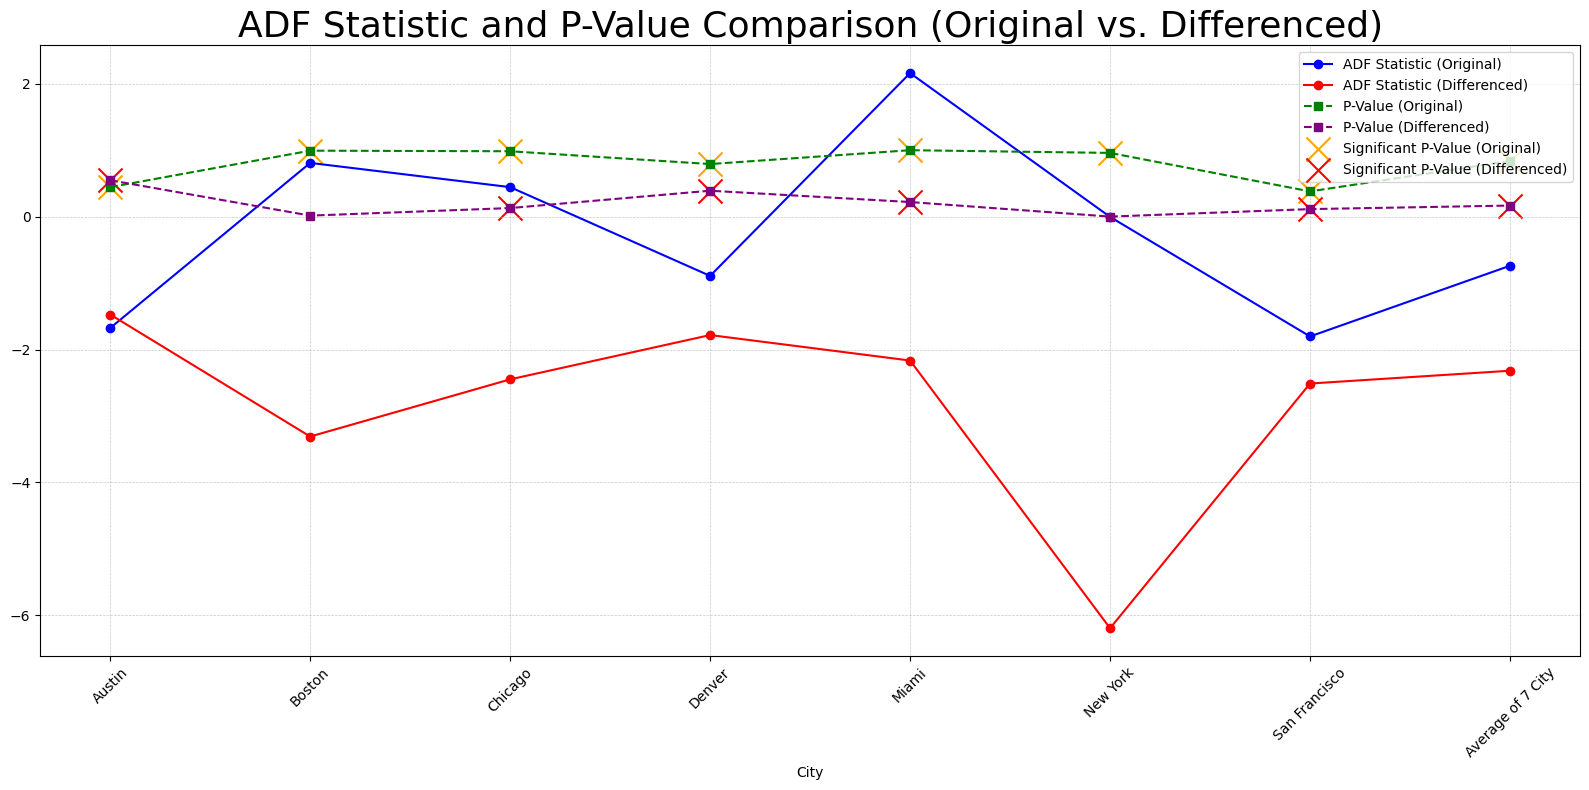

In [28]:
adf_stats_original = adf_results['ADF Statistic']
p_values_original = adf_results['P-Value']
adf_stats_differenced = adf_results_differenced['ADF Statistic']
p_values_differenced = adf_results_differenced['P-Value']

# List of unique cities
cities = adf_results['City']

# Create a wider plot to compare ADF Statistic and P-Value
plt.figure(figsize=(16, 8))

# Plot ADF Statistic for original data (blue line)
plt.plot(cities, adf_stats_original, color='blue', marker='o', linestyle='-', label='ADF Statistic (Original)')

# Plot ADF Statistic for differenced data (red line)
plt.plot(cities, adf_stats_differenced, color='red', marker='o', linestyle='-', label='ADF Statistic (Differenced)')

# Plot P-Values for original data (green line)
plt.plot(cities, p_values_original, color='green', marker='s', linestyle='--', label='P-Value (Original)')

# Plot P-Values for differenced data (purple line)
plt.plot(cities, p_values_differenced, color='purple', marker='s', linestyle='--', label='P-Value (Differenced)')

# Highlight significant P-Values (less than 0.05) with a different marker
significant_p_values_indices = np.where(p_values_original > 0.05)[0]
significant_p_values = p_values_original[significant_p_values_indices]


significant_p_values_indices_differenced = np.where(p_values_differenced > 0.05)[0]
significant_p_values_differenced = p_values_differenced[significant_p_values_indices_differenced]


plt.scatter(cities[significant_p_values_indices], significant_p_values, color='orange', marker='x', s=300, label='Significant P-Value (Original)')

plt.scatter(cities[significant_p_values_indices_differenced], significant_p_values_differenced, color='red', marker='x', s=300, label='Significant P-Value (Differenced)')

# Add labels and legend
plt.xlabel('City')
plt.title('ADF Statistic and P-Value Comparison (Original vs. Differenced)', fontsize=26)
plt.xticks(rotation=45)
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

## KPSS Test  
- The KPSS test is an alternative test for stationarity. It checks whether the data is stationary around a constant mean or a deterministic trend.<br>
- The null hypothesis of the KPSS test is that the data is stationary.<br>
- If the p-value from the KPSS test is greater than the significance level, you can conclude that the time series is stationary.

### While this test can be applied to the data, I think we already have sufficient observations on our data.

In [29]:
# Save data.
subset_df.to_csv('../data/data_for_prediction.csv', index=False)
subset_df

period_begin period_end               city    property_type  \
3     2015-08-01 2015-08-31             Austin  All Residential   
4     2015-09-01 2015-09-30             Austin  All Residential   
5     2015-10-01 2015-10-31             Austin  All Residential   
6     2015-11-01 2015-11-30             Austin  All Residential   
7     2015-12-01 2015-12-31             Austin  All Residential   
..           ...        ...                ...              ...   
875   2024-02-01 2024-02-29  Average of 7 City  All Residential   
876   2024-03-01 2024-03-31  Average of 7 City  All Residential   
877   2024-04-01 2024-04-30  Average of 7 City  All Residential   
878   2024-05-01 2024-05-31  Average of 7 City  All Residential   
879   2024-06-01 2024-06-30  Average of 7 City  All Residential   

     median_sale_price  median_sale_price_diff  median_sale_price_diff2  
3         262461.00000             -2539.00000               4461.00000  
4         255000.00000             -7461.00000              -4922.00000  
5         255000.00000                 0.00000               7461.00000  
6         270000.00000             15000.00000              15000.00000  
7         271500.00000              1500.00000             -13500.00000  
..                 ...                     ...                      ...  
875       662282.00000              1665.00000             -19906.00000  
876       701162.00000             38880.00000              37215.00000  
877       709257.00000              8095.00000             -30785.00000  
878       711992.00000              2735.00000              -5360.00000  
879       725928.00000             13936.00000              11201.00000  

[856 rows x 7 columns]